# Analysis of IMB

This notebook performs data analysis of the csv files created by running the IMB benchmark

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
import re

# Standardise Fonts
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 
plt.rc('axes', titlesize=11)
plt.rc("axes", labelsize=10)

In [2]:
MBPS = "$\mathregular{MBs^{-1}}$"
USEC = "$\mathregular{\mu s}$"

In [3]:
results = {
    "Cloud_IMB":[],
    "SCARF_IMB":[],
    "SCARF_IMB_CPUs": [],
    "JASMIN_IMB":[],
    "JASMIN_IMB_CPUs": []
}

for dataName in results:
    with open("../" + dataName + "/out.csv", "r") as fHandle:
        reader = csv.reader(fHandle)  # create an iterator over each row
        headers = next(reader) # the headers are the first line
        latencyIndex = headers.index("Latency")  #
        bandwidthIndex = headers.index("0")  # after here, all are the bandwidths
        thisMessageSizes = [int(el) for el in headers[bandwidthIndex + 1:]]
        try:
            if messageSizes != [int(el) for el in headers[bandwidthIndex + 1:]]:
                raise ValueError("Different message sizes")
        except NameError: # if messageSizes hasn't been set yet
            messageSizes = thisMessageSizes
        for row in reader:
            thisRow = dict((header, row[index]) for index, header in enumerate(headers))
            thisRow["Bandwidths"] = [float(el) for el in row[bandwidthIndex + 1:]]
            thisRow["Max Bandwidth"] = max(thisRow["Bandwidths"])
            thisRow["Mean Bandwidths"] = sum(thisRow["Bandwidths"]) / len(thisRow["Bandwidths"])
            results[dataName].append(thisRow)
print("Message Sizes:")
print(messageSizes)
print()
for dataName in results:
    print(dataName)
    print("1st latency:        {}".format(results[dataName][0]["Latency"]))
    print("max bandwidth:      {}".format(max(test["Max Bandwidth"] for test in results[dataName])))
    print("1st bandwidths(10): {}".format(results[dataName][0]["Bandwidths"][0:10]))
    print("Headers:            {}".format(results[dataName][0].keys()))
    print()
        

Message Sizes:
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]

JASMIN_IMB
1st latency:        0.14
max bandwidth:      11469.57
1st bandwidths(10): [6.02, 12.55, 25.1, 48.93, 99.77, 197.53, 310.68, 465.03, 876.71, 1484.06]
Headers:            dict_keys(['Mean Bandwidths', 'Latency', 'Hosts Used', '4194304', 'Average Memory (MB)', 'CPU time (sec.)', '0', '8192', '1048576', '2', 'Max Memory (MB)', '1', 'Max Processes', '2048', 'Exclusive', '131072', '262144', 'Max Threads', '512', '256', '524288', '4', '128', 'Delta Memory (MB)', 'Number of Hosts', 'Bandwidths', '16384', '65536', 'File Name', '32', '16777216', '8388608', '16', '1024', 'Max Bandwidth', '2097152', 'Host Groups', '4096', '64', '8', 'Protocols Seen', 'Total Requested Memory (MB)', 'Max Swap (MB)', '32768'])

JASMIN_IMB_CPUs
1st latency:        0.33
max bandwidth:      11564.0
1st bandwidths(10): [2.99, 5.9, 11.77, 23.2

In [4]:
import datetime

# Do cloud dates:
for result in results["Cloud_IMB"]:
    result["Date Run"] = datetime.datetime.strptime(result["File Name"], "%Y%m%d_%H%M%S.out")

# Make SCARF uppercase and map 'X-X' -> 'X'
for name in ("SCARF_IMB", "JASMIN_IMB", "SCARF_IMB_CPUs", "JASMIN_IMB_CPUs"):
    for result in results[name]:
        result["Host Groups"] = result["Host Groups"].split("-")[0]
        # Replace SHM-TCP and SHM-IBV with TCP and IBV
        try:
            result["Protocols Seen"] = result["Protocols Seen"].split("-")[1]
        except IndexError:
            # Don't replace SHM with ''
            pass

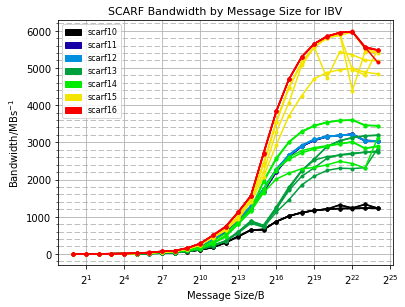

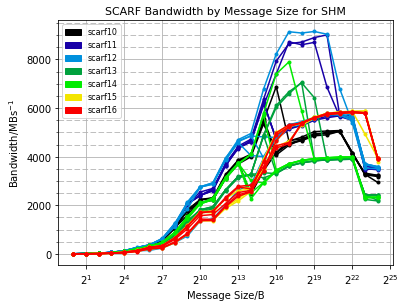

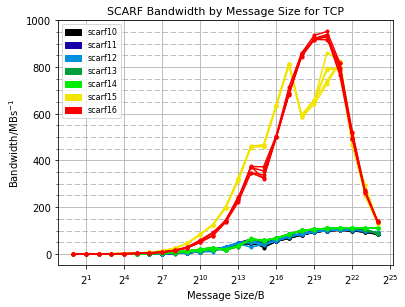

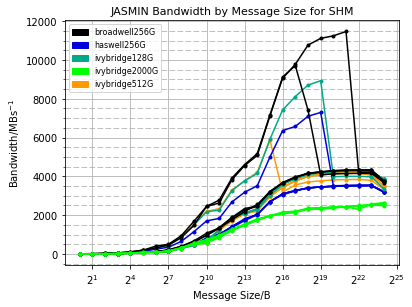

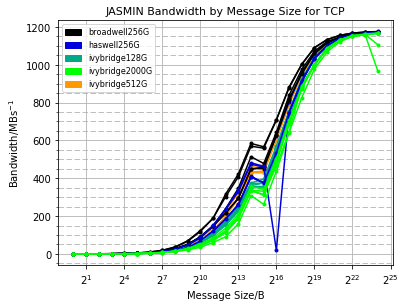

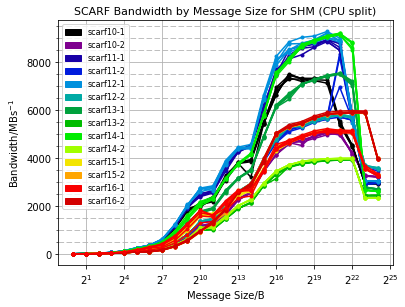

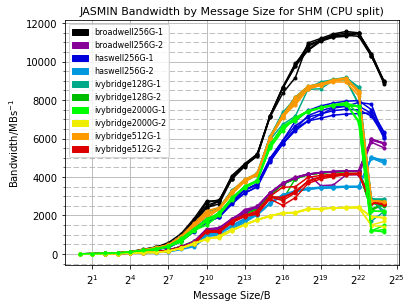

In [5]:
def plotBandwidth():
    for name in ("SCARF_IMB", "JASMIN_IMB", "SCARF_IMB_CPUs", "JASMIN_IMB_CPUs"):
        protocols = sorted(set(row["Protocols Seen"] for row in results[name]))
        for prot in protocols:
            res = [row for row in results[name] if row["Protocols Seen"] == prot]
            hostgroups = sorted(set(row["Host Groups"] for row in res))
            clrMap = plt.get_cmap("nipy_spectral")
            legendHandles = []
            plt.rcParams["figure.figsize"] = (6, 4.5)
            for index, hostgroup in enumerate(hostgroups):
                if "CPUs" not in name:
                    clr = clrMap(index / len(hostgroups))
                    legendHandles.append(mpatches.Patch(color=clr, label=hostgroup))
                else:
                    for numCPUs in ("1", "2"):
                        clr = clrMap((2 * index + int(numCPUs) - 1) / (2 * len(hostgroups)))
                        legendHandles.append(mpatches.Patch(color=clr, label=hostgroup + "-" + numCPUs))
            for index, row in enumerate(sorted(res, key=lambda el: el["File Name"])):
                band = row["Bandwidths"]
                clr = (clrMap(hostgroups.index(row["Host Groups"]) / len(hostgroups)) 
                       if "CPUs" not in name else
                       clrMap((2 * hostgroups.index(row["Host Groups"]) + int(row["CPUs"]) - 1) / (2 * len(hostgroups)))
                       )
                clr = (clr[0], clr[1], clr[2], 1)
                plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
                nodeNumbers = ",".join(re.findall("cn\d+", row["Hosts Used"]))
                # legendHandles.append(mpatches.Patch(color=clr, label=nodeNumbers))
            plt.legend(handles=legendHandles, loc=2, ncol=1, fontsize=8)
            plt.xscale("log", basex=2)
            # plt.yscale("log")
            endOfTitle = prot
            endOfTitle += " (CPU split)" if "CPUs" in name else ""
            title = "{} Bandwidth by Message Size for {}".format(name.split("_")[0], endOfTitle)
            plt.title(title)
            plt.xlabel("Message Size/B")
            plt.ylabel("Bandwidth/" + MBPS)
            plt.grid(True, which="minor", linestyle="--")
            plt.grid(True, which="major", linestyle="-")
            plt.minorticks_on()
            plt.show()
plotBandwidth()


7628.87 2017-03-22 08:25:02
7717.49 2017-03-22 08:45:01
7392.39 2017-03-22 09:05:01
6424.77 2017-03-22 09:25:01
7513.5 2017-03-22 09:45:01
6094.18 2017-03-22 10:05:01
6156.5 2017-03-22 10:25:01
5342.77 2017-03-22 10:45:01
6542.19 2017-03-22 11:05:01
4633.29 2017-03-22 11:25:01
6843.13 2017-03-22 11:45:01
7407.45 2017-03-22 12:05:01
7576.19 2017-03-22 12:25:01
6383.82 2017-03-22 12:45:01
3524.63 2017-03-22 13:05:01
6826.0 2017-03-22 13:25:01
6364.48 2017-03-22 13:45:01
6854.28 2017-03-22 14:05:01
6718.73 2017-03-22 14:25:01
6220.2 2017-03-22 14:45:01
6490.46 2017-03-22 15:05:02
7589.33 2017-03-22 15:25:01
6831.94 2017-03-22 15:45:01
5781.92 2017-03-22 16:05:01
6249.51 2017-03-22 16:25:01
6269.96 2017-03-22 16:45:01
6537.59 2017-03-22 17:05:01
6585.86 2017-03-22 17:25:01
6339.3 2017-03-22 17:45:01
6287.38 2017-03-22 18:05:01


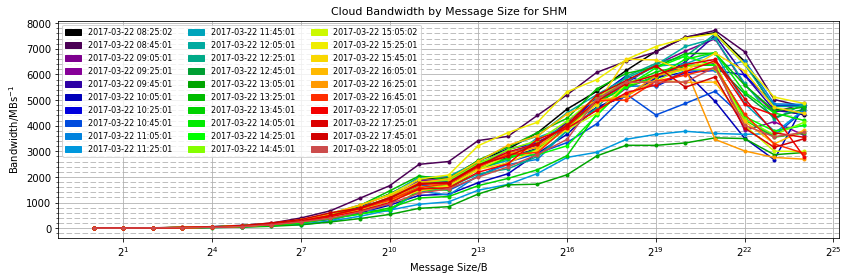

406.85 2017-03-22 18:25:01
415.95 2017-03-22 18:45:01
443.3 2017-03-22 19:05:01
454.11 2017-03-22 19:25:01
469.4 2017-03-22 19:45:01
442.01 2017-03-22 20:05:01
427.32 2017-03-22 20:25:01
446.73 2017-03-22 20:45:01
463.5 2017-03-22 21:05:01
463.39 2017-03-22 21:25:01
506.17 2017-03-22 21:45:01
481.18 2017-03-22 22:05:01
452.82 2017-03-22 22:25:01
423.51 2017-03-22 22:45:01
442.05 2017-03-22 23:05:01
433.91 2017-03-22 23:25:01
504.18 2017-03-22 23:45:01
479.56 2017-03-23 00:05:01
469.15 2017-03-23 00:25:01
419.55 2017-03-23 00:45:01
474.93 2017-03-23 01:05:01
498.0 2017-03-23 01:25:01
460.84 2017-03-23 01:45:01
457.94 2017-03-23 02:05:01
457.1 2017-03-23 02:25:01
453.74 2017-03-23 02:45:01
469.02 2017-03-23 03:05:01
464.96 2017-03-23 03:25:01
469.52 2017-03-23 03:45:01
441.89 2017-03-23 04:05:01


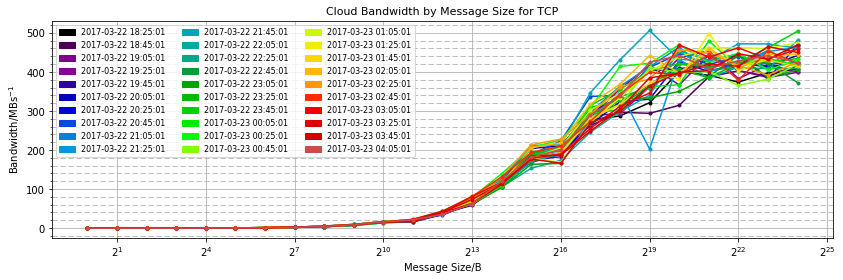

In [6]:
def plotCloudBandwidth():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    for numHosts in numHostsSet:
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        clrMap = plt.get_cmap("nipy_spectral")
        legendHandles = []
        plt.rcParams["figure.figsize"] = (14, 4)
        for index, row in enumerate(sorted(res, key=lambda el: el["Date Run"])):  # sort by date run
            band = row["Bandwidths"]
            print(max(band), row["Date Run"])
            clr = clrMap(index / len(res))
            clr = (clr[0], clr[1], clr[2], 1)
            plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
            legendHandles.append(mpatches.Patch(color=clr, label=row["Date Run"]))
        plt.legend(handles=legendHandles, loc=2, ncol=3, fontsize=8)
        plt.xscale("log", basex=2)
        titleEnd = "SHM" if numHosts == "1" else "TCP"
        plt.title("Cloud Bandwidth by Message Size for " + titleEnd)
        plt.xlabel("Message Size/B")
        plt.ylabel("Bandwidth/" + MBPS)
        plt.grid(True, which="minor", linestyle="--")
        plt.grid(True, which="major", linestyle="-")
        plt.minorticks_on()
        plt.show()

plotCloudBandwidth()


['1', '2']


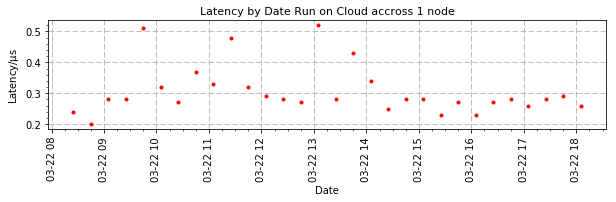

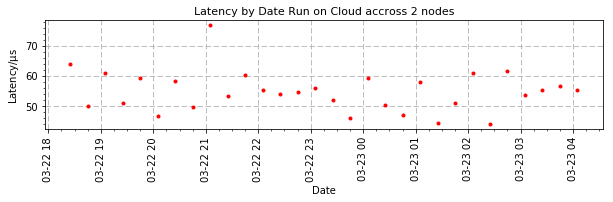

In [7]:
def plotCloudLatencies():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    print(numHostsSet)
    
    for index, numHosts in enumerate(numHostsSet):
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        plt.rcParams["figure.figsize"] = (10,2)
        plt.plot([row["Date Run"] for row in res], 
                 [row["Latency"] for row in res], "r.")
        plt.xticks(rotation='vertical')
        titleEnd = "1 node" if numHosts == "1" else "{} nodes".format(numHosts)
        plt.title("Latency by Date Run on Cloud accross " + titleEnd)
        plt.ylabel("Latency/" + USEC)
        plt.xlabel("Date")
        #plt.grid(True, which="minor", linestyle="-")
        plt.grid(True, which="major", linestyle="--")
        plt.minorticks_on()
        plt.show()

plotCloudLatencies()

Cloud & 6504.27 & 6504.27 & 456.42 & n/a\\
scarf10 & 7419.95 & 5048.19 & 101.54 & 1270.66\\
scarf11 & 8877.11 & 6974.27 & 103.09 & 3215.99\\
scarf12 & 9121.70 & 5787.32 & 102.91 & 3207.53\\
scarf13 & 7504.84 & 3927.28 & 110.51 & 2940.26\\
scarf14 & 9153.45 & 3973.65 & 111.81 & 3267.56\\
scarf15 & 5145.80 & 5876.91 & 825.88 & 5670.07\\
scarf16 & 5140.57 & 5905.49 & 934.16 & 5975.28\\
broadwell256G & 11468.01 & 5920.18 & 1174.91 & n/a\\
haswell256G & 7683.80 & 5006.57 & 1171.09 & n/a\\
ivybridge128G & 9115.23 & 4299.59 & 1172.70 & n/a\\
ivybridge2000G & 7808.32 & 2417.75 & 1163.62 & n/a\\
ivybridge512G & 9082.18 & 4167.02 & 1172.76 & n/a\\



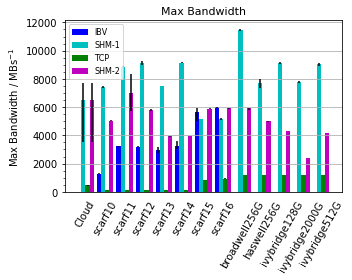

Cloud & 2401.67 & 2401.67 & 151.05 & n/a\\
scarf10 & 3056.89 & 2120.90 & 38.51 & 514.12\\
scarf11 & 3610.66 & 2447.34 & 40.98 & 1273.50\\
scarf12 & 3732.07 & 2466.04 & 40.21 & 1283.44\\
scarf13 & 3011.14 & 1711.51 & 44.19 & 975.60\\
scarf14 & 3602.87 & 1753.92 & 46.03 & 1251.12\\
scarf15 & 2310.03 & 2536.46 & 276.29 & 2038.06\\
scarf16 & 2307.51 & 2546.35 & 275.17 & 2219.58\\
broadwell256G & 4945.66 & 2155.01 & 454.26 & n/a\\
haswell256G & 3366.90 & 1771.72 & 421.55 & n/a\\
ivybridge128G & 3576.70 & 1867.79 & 412.06 & n/a\\
ivybridge2000G & 3086.84 & 1160.97 & 390.91 & n/a\\
ivybridge512G & 3581.95 & 1758.50 & 430.23 & n/a\\



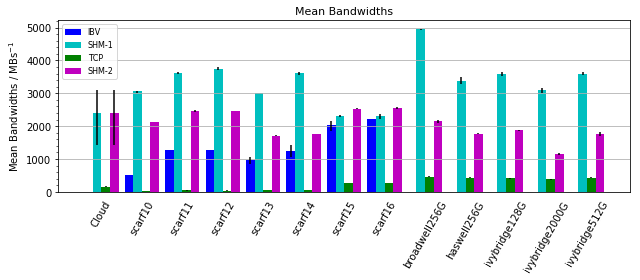

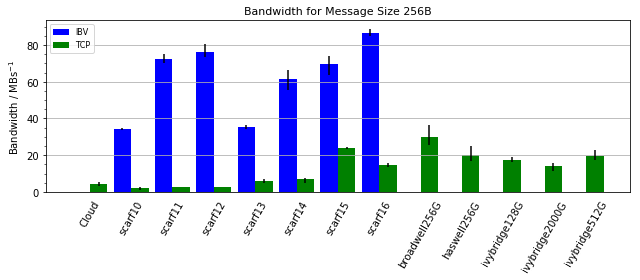

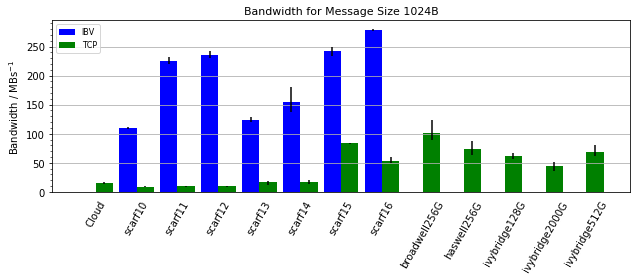

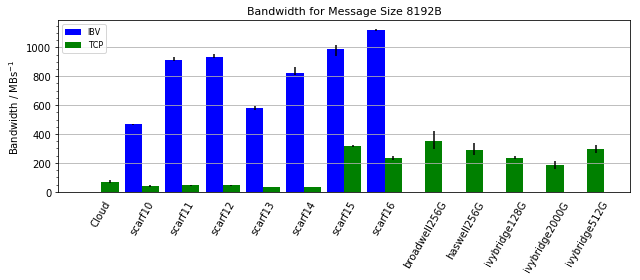

Cloud & 1086.01 & 1086.01 & 15.58 & n/a\\
scarf10 & 2035.05 & 1132.61 & 8.90 & 109.43\\
scarf11 & 2443.99 & 1318.35 & 9.63 & 225.26\\
scarf12 & 2694.70 & 1355.99 & 9.30 & 234.97\\
scarf13 & 1739.76 & 995.17 & 16.31 & 123.09\\
scarf14 & 2103.48 & 1058.89 & 17.76 & 154.32\\
scarf15 & 1659.08 & 927.46 & 83.44 & 243.07\\
scarf16 & 1644.23 & 942.36 & 53.18 & 278.32\\
broadwell256G & 2547.62 & 1263.69 & 102.12 & n/a\\
haswell256G & 1724.22 & 975.50 & 73.79 & n/a\\
ivybridge128G & 2121.81 & 1127.32 & 60.85 & n/a\\
ivybridge2000G & 1695.40 & 775.68 & 44.79 & n/a\\
ivybridge512G & 2065.02 & 1167.25 & 69.32 & n/a\\



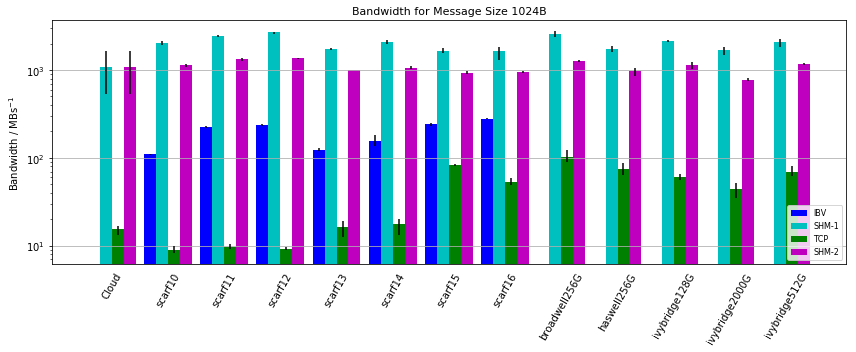

Cloud & 2331.78 & 2331.78 & 70.82 & n/a\\
scarf10 & 3786.75 & 2269.98 & 39.92 & 468.49\\
scarf11 & 4266.71 & 2559.63 & 45.96 & 913.84\\
scarf12 & 4399.96 & 2601.34 & 45.63 & 935.66\\
scarf13 & 3153.47 & 1891.89 & 32.81 & 579.11\\
scarf14 & 3735.09 & 2005.55 & 33.34 & 822.42\\
scarf15 & 2513.02 & 2563.46 & 318.38 & 988.26\\
scarf16 & 2566.26 & 2568.84 & 233.96 & 1122.51\\
broadwell256G & 4615.70 & 2204.37 & 352.73 & n/a\\
haswell256G & 3248.41 & 1752.09 & 289.13 & n/a\\
ivybridge128G & 3794.90 & 2106.11 & 235.51 & n/a\\
ivybridge2000G & 3479.32 & 1514.62 & 188.94 & n/a\\
ivybridge512G & 3785.00 & 1983.11 & 295.25 & n/a\\



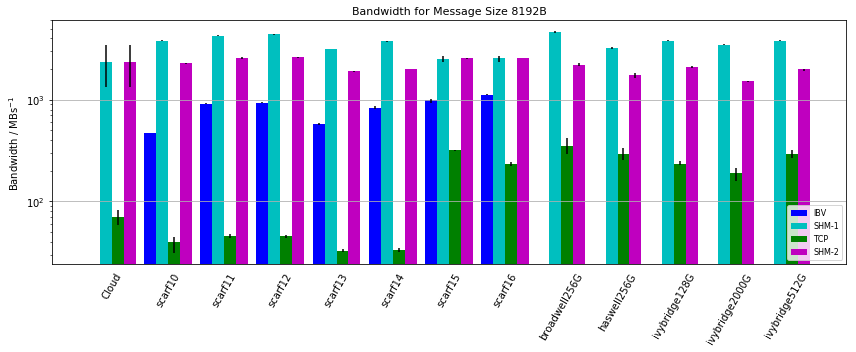

Cloud & 3164.26 & 3164.26 & 184.26 & n/a\\
scarf10 & 5432.64 & 3478.14 & 34.99 & 654.38\\
scarf11 & 6071.52 & 3879.78 & 48.05 & 1699.70\\
scarf12 & 6503.35 & 3952.47 & 40.03 & 1743.98\\
scarf13 & 4855.00 & 2841.63 & 55.67 & 747.12\\
scarf14 & 5775.77 & 2931.54 & 56.77 & 1796.93\\
scarf15 & 3486.68 & 3905.40 & 463.96 & 2308.61\\
scarf16 & 3473.62 & 3881.20 & 342.79 & 2702.85\\
broadwell256G & 7150.79 & 3160.15 & 502.72 & n/a\\
haswell256G & 4872.27 & 2633.92 & 409.64 & n/a\\
ivybridge128G & 6045.88 & 3041.11 & 371.36 & n/a\\
ivybridge2000G & 5605.09 & 1968.71 & 311.79 & n/a\\
ivybridge512G & 6033.94 & 2946.58 & 429.37 & n/a\\



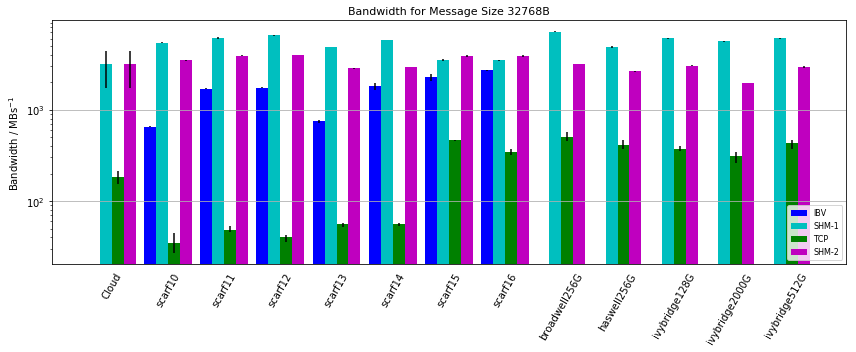

Cloud & 6504.27 & 6504.27 & 456.42 & n/a\\
scarf10 & 7419.95 & 5048.19 & 101.54 & 1270.66\\
scarf11 & 8877.11 & 6974.27 & 103.09 & 3215.99\\
scarf12 & 9121.70 & 5787.32 & 102.91 & 3207.53\\
scarf13 & 7504.84 & 3927.28 & 110.51 & 2940.26\\
scarf14 & 9153.45 & 3973.65 & 111.81 & 3267.56\\
scarf15 & 5145.80 & 5876.91 & 825.88 & 5670.07\\
scarf16 & 5140.57 & 5905.49 & 934.16 & 5975.28\\
broadwell256G & 11468.01 & 5920.18 & 1174.91 & n/a\\
haswell256G & 7683.80 & 5006.57 & 1171.09 & n/a\\
ivybridge128G & 9115.23 & 4299.59 & 1172.70 & n/a\\
ivybridge2000G & 7808.32 & 2417.75 & 1163.62 & n/a\\
ivybridge512G & 9082.18 & 4167.02 & 1172.76 & n/a\\



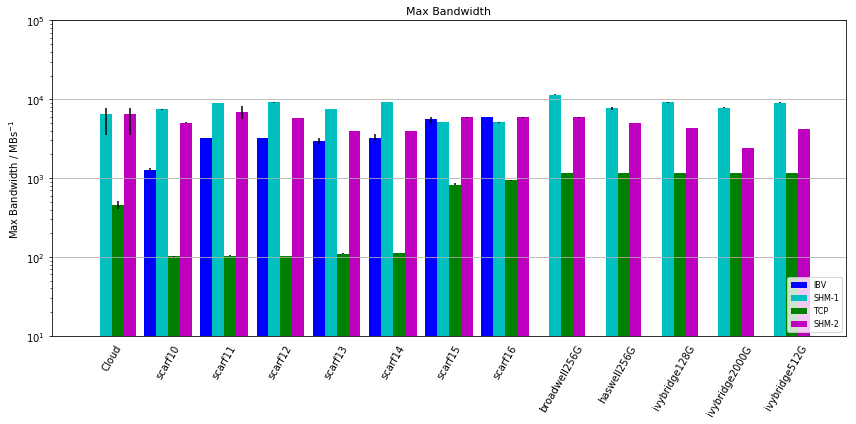

Cloud & 0.31 & 0.31 & 54.74 & n/a\\
scarf10 & 0.16 & 0.32 & 89.49 & 4.38\\
scarf11 & 0.12 & 0.24 & 77.21 & 1.83\\
scarf12 & 0.11 & 0.23 & 83.53 & 1.71\\
scarf13 & 0.16 & 0.31 & 35.22 & 6.55\\
scarf14 & 0.13 & 0.32 & 26.93 & 2.22\\
scarf15 & 0.21 & 0.34 & 9.70 & 2.02\\
scarf16 & 0.22 & 0.34 & 16.44 & 1.47\\
broadwell256G & 0.14 & 0.30 & 7.17 & n/a\\
haswell256G & 0.19 & 0.37 & 11.05 & n/a\\
ivybridge128G & 0.13 & 0.32 & 11.99 & n/a\\
ivybridge2000G & 0.16 & 0.39 & 15.90 & n/a\\
ivybridge512G & 0.13 & 0.40 & 10.89 & n/a\\



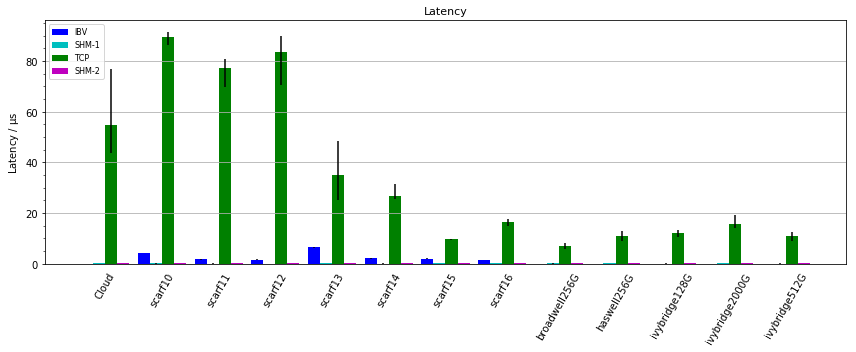

Cloud & 0.31 & 0.31 & 54.74 & n/a\\
scarf10 & 0.16 & 0.32 & 89.49 & 4.38\\
scarf11 & 0.12 & 0.24 & 77.21 & 1.83\\
scarf12 & 0.11 & 0.23 & 83.53 & 1.71\\
scarf13 & 0.16 & 0.31 & 35.22 & 6.55\\
scarf14 & 0.13 & 0.32 & 26.93 & 2.22\\
scarf15 & 0.21 & 0.34 & 9.70 & 2.02\\
scarf16 & 0.22 & 0.34 & 16.44 & 1.47\\
broadwell256G & 0.14 & 0.30 & 7.17 & n/a\\
haswell256G & 0.19 & 0.37 & 11.05 & n/a\\
ivybridge128G & 0.13 & 0.32 & 11.99 & n/a\\
ivybridge2000G & 0.16 & 0.39 & 15.90 & n/a\\
ivybridge512G & 0.13 & 0.40 & 10.89 & n/a\\



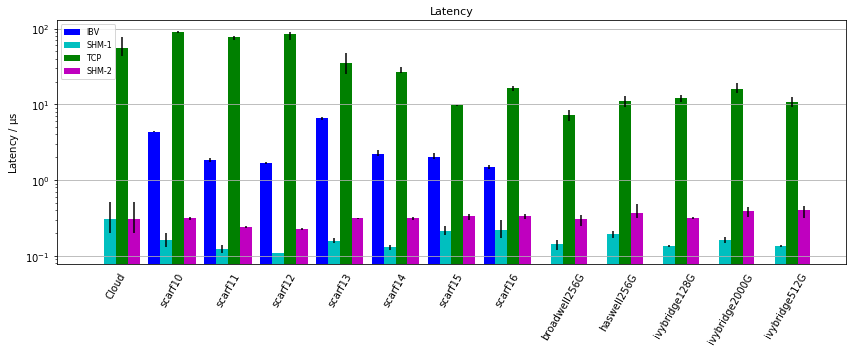

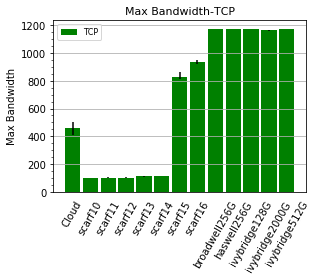

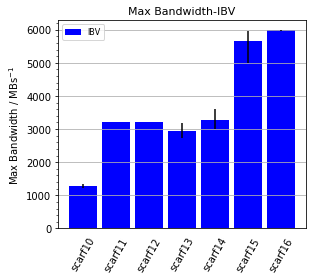

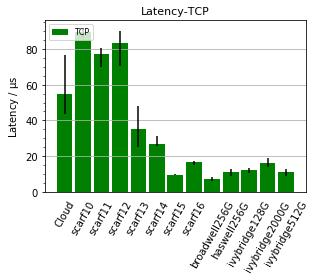

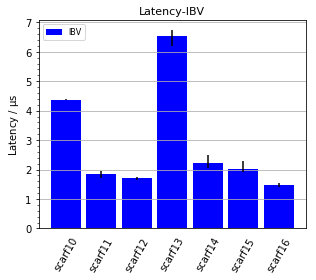

In [10]:
def makeLatexTableContent(xValues, yValues):
#    for i, (label, yVals) in enumerate(yValues.items())
#         plt.bar(index + i * bar_width, yVals, bar_width, align='center', color=clrs[label], alpha=0.7, label=label)
#         plt.errorbar(index + i * bar_width, yVals, yerr=[yBottomError[label], yTopError[label]], linestyle=" ", color="black")
    toRtn = ""
    for rowNum, hostGroup in enumerate(xValues):
        data = [format(round(yValues[key][rowNum]*100)/100, ".2f") if yValues[key][rowNum] != 0
                else "n/a"
                
                
                for key in ["SHM-1", "SHM-2", "TCP", "IBV"]]
        DELIM = " & "
        toRtn += hostGroup + DELIM + DELIM.join(data) + r"\\" + "\n"
    return toRtn

def plotBar(KEY, HOSTGROUPS, PROTOCOLS, UNITS=None, FIGSIZE=(4.5, 4), logY=False, LEG_HAND_POS=2, YLIM=None, SAVE=None):
    clrs = {"SHM": "r", "TCP":"g", "IBV":"b", "SHM-1":"c", "SHM-2":"m"}
    yValues = dict((prot, []) for prot in PROTOCOLS)
    yTopError = dict((prot, []) for prot in PROTOCOLS)
    yBottomError = dict((prot, []) for prot in PROTOCOLS)
    xValues = []
    
    def addBarData(listOfBandwidths, label):
        if label in PROTOCOLS:
            listOfBandwidths = [float(val) for val in listOfBandwidths]
            nonlocal yValues
            nonlocal yTopError
            nonlocal yBottomError
            avg = sum(listOfBandwidths) / len(listOfBandwidths)
            yValues[label].append(avg)
            yTopError[label].append(max(listOfBandwidths) - avg)
            yBottomError[label].append(avg - min(listOfBandwidths))
    
    if "Cloud" in HOSTGROUPS:
        # Add the cloud split into number of hosts
        cloudSHMres = [row[KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "1"]
        addBarData(cloudSHMres, "SHM")
        addBarData([row[KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "2"], "TCP")
        addBarData([0], "IBV")
        addBarData(cloudSHMres, "SHM-1")
        addBarData(cloudSHMres, "SHM-2")
        xValues.append("Cloud")
    
    
    # Add the SCARF and JASMIN data split into host group and number of hosts
    for name in ("SCARF_IMB", "JASMIN_IMB"):
        for hostgroup in sorted(set(row["Host Groups"] for row in results[name])):
            if hostgroup not in HOSTGROUPS:
                continue
            xValues.append(hostgroup)
            for prot in PROTOCOLS:
                if prot in ("SHM-1", "SHM-2"):
                    continue  # skip this for later
                thisData = [row[KEY] for row in results[name] 
                            if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"]]
                if len(thisData) == 0:  # if no data then there is a divide by zero so send this (mostly IBV)
                    addBarData([0], prot)
                else:
                    addBarData(thisData, prot)
                    
    # Add the SCARF and JASMIN data split into host group and number of hosts
    if "SHM-1" in PROTOCOLS and "SHM-2" in PROTOCOLS:
        for name in ("SCARF_IMB_CPUs", "JASMIN_IMB_CPUs"):  # must be scarf then jasmin (same order as above)
            for hostgroup in sorted(set(row["Host Groups"] for row in results[name])):
                if hostgroup not in HOSTGROUPS:
                    continue
                for numCPUs in ("1", "2"):
                    thisData = [row[KEY] for row in results[name] 
                                if hostgroup in row["Host Groups"] and numCPUs == row["CPUs"]]
                    addBarData(thisData, "SHM-" + numCPUs)
    
    index = np.arange(len(xValues)) - 1
    
    bar_width = 0.85 / len(PROTOCOLS)
    plt.rcParams["figure.figsize"] = FIGSIZE
    ax = plt.gca()
    plt.minorticks_on()
    ax.yaxis.grid(True, which='major', linestyle='-')
#     ax.yaxis.grid(True, which='minor', linestyle='--')
    
    for i, (label, yVals) in enumerate(yValues.items()):
        plt.bar(index + i * bar_width, yVals, bar_width, align='center', color=clrs[label], label=label)
        plt.errorbar(index + i * bar_width, yVals, yerr=[yBottomError[label], yTopError[label]], linestyle=" ", color="black")
        
        
    if len(PROTOCOLS) == 4:
        print(makeLatexTableContent(xValues, yValues))

    
    plt.xticks(index + ((len(PROTOCOLS) - 1) / 2) * bar_width, xValues, rotation=60)
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    
    unitsEnd = " / " + UNITS if UNITS is not None else ""
    if all(i.isdigit() for i in KEY): # if the key is a natural number, make y label 'bandwidth'
        plotTitle = "Bandwidth for Message Size " + KEY + "B"
        plt.ylabel("Bandwidth" + unitsEnd)
    else:
        # Otherwise it is 'Latency', 'Max Bandwidth' or 'Mean Bandwidth' so use the KEY itself
        plt.ylabel(KEY + unitsEnd)
        plotTitle = KEY
    if logY:
        plt.yscale("log")
    plotTitle += "" if len(PROTOCOLS) > 1 else "-" + PROTOCOLS[0]
    # if logY: plotTitle += " - Log Scale" 
    plt.title(plotTitle)
    
    try:
        plt.legend(loc=LEG_HAND_POS, fontsize=8)
    except IndexError:
        print(yValues.items())
        print(KEY, HOSTGROUPS, PROTOCOLS, UNITS, FIGSIZE)
    plt.tight_layout()
    
    if YLIM is not None:
        plt.ylim(*YLIM)
    
    if SAVE is not None:
        plt.savefig(SAVE + '.png', format="png")
    
    plt.show()
    
    
# Get the set of hostgroups    
hgs = set(result["Host Groups"] for name in ("SCARF_IMB", "JASMIN_IMB") for result in results[name] )
hgs.add("Cloud")

# Do bandwidths with all protocols
plotBar("Max Bandwidth", hgs, ["SHM-1", "SHM-2", "TCP", "IBV"], MBPS, FIGSIZE=(5,4))
plotBar("Mean Bandwidths", hgs, ["SHM-1", "SHM-2", "TCP", "IBV"], MBPS, FIGSIZE=(9,4))
plotBar("256", hgs, ["TCP", "IBV"], MBPS, FIGSIZE=(9,4))
plotBar("1024", hgs, ["TCP", "IBV"], MBPS, FIGSIZE=(9,4))
plotBar("8192", hgs, ["TCP", "IBV"], MBPS, FIGSIZE=(9,4))


plotBar("1024", hgs, ["SHM-1", "SHM-2", "TCP", "IBV"], MBPS, logY=True, FIGSIZE=(12,5), LEG_HAND_POS=4,
        SAVE="compare_bandwidth-hostgroup_1024")
plotBar("8192", hgs, ["SHM-1", "SHM-2", "TCP", "IBV"], MBPS, logY=True, FIGSIZE=(12,5), LEG_HAND_POS=4,
        SAVE="compare_bandwidth-hostgroup_8192")
plotBar("32768", hgs, ["SHM-1", "SHM-2", "TCP", "IBV"], MBPS, logY=True,FIGSIZE=(12,5), LEG_HAND_POS=4,
        SAVE="compare_bandwidth-hostgroup_32768")
plotBar("Max Bandwidth", hgs, ["SHM-1", "SHM-2", "TCP", "IBV"], MBPS, logY=True, FIGSIZE=(12,6), LEG_HAND_POS=4,
        YLIM=(10, 10**5),
        SAVE="compare_bandwidth-hostgroup_max")

# Do lactency with all protocols
plotBar("Latency", hgs, ["SHM-1", "SHM-2", "TCP", "IBV"], USEC, FIGSIZE=(12,5))
plotBar("Latency", hgs, ["SHM-1", "SHM-2", "TCP", "IBV"], USEC, logY=True, FIGSIZE=(12,5),
        SAVE="compare_latency-hostgroup")


# Do bandwidths for single protocols
plotBar("Max Bandwidth", hgs, ["TCP"], )
plotBar("Max Bandwidth", [hg for hg in hgs if "scarf" in hg], ["IBV"], MBPS)
# plotBar("Max Bandwidth", hgs, ["SHM"], MBPS)

# Do Latency for single protocols
plotBar("Latency", hgs, ["TCP"], USEC)
plotBar("Latency", [hg for hg in hgs if "scarf" in hg], ["IBV"], USEC )
# plotBar("Latency", hgs, ["SHM"], USEC)

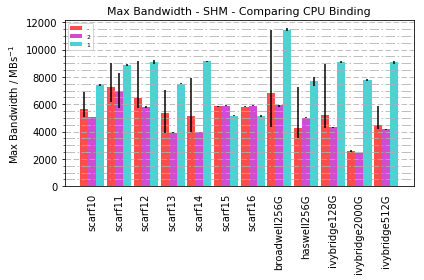

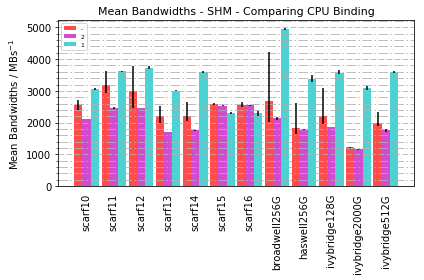

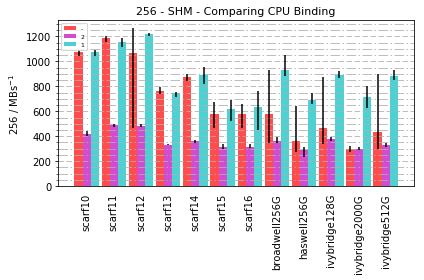

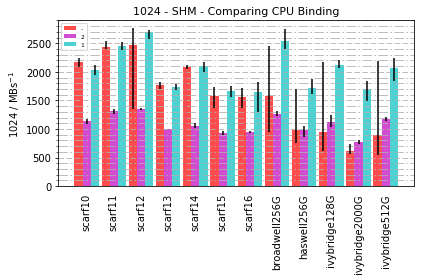

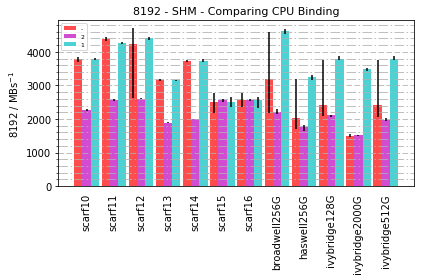

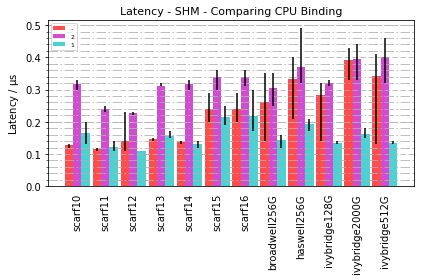

In [9]:
def plotBarCompareCPU(KEY, UNITS=None):
    CPUs = ["-","1", "2"]
    clrs = {"1":"c", "2":"m", "-":"r"}
    yValues = dict((CPU, []) for CPU in CPUs)
    yTopError = dict((CPU, []) for CPU in CPUs)
    yBottomError = dict((CPU, []) for CPU in CPUs)
    xValues = []
    
    def addBarData(listOfBandwidths, label):
        listOfBandwidths = [float(val) for val in listOfBandwidths]
        nonlocal yValues
        nonlocal yTopError
        nonlocal yBottomError
        avg = sum(listOfBandwidths) / len(listOfBandwidths)
        yValues[label].append(avg)
        yTopError[label].append(max(listOfBandwidths) - avg)
        yBottomError[label].append(avg - min(listOfBandwidths))
    
    
    
    for infra in ("SCARF", "JASMIN"):
        specificCPUs = "{}_IMB_CPUs".format(infra)
        randomCPUs = "{}_IMB".format(infra)
        # Use specific CPUs for getting the hostgroups, JASMIN has some extra hostgroups in random
        hostgroups = sorted(set(row["Host Groups"] for row in results[specificCPUs]))
        xValues += hostgroups
        for resultName in (randomCPUs, specificCPUs):
            for hostgroup in hostgroups:
                if "CPUs" in resultName:
                    # If specific CPUs, add two bars (one for each CPU setting)
                    for CPU in CPUs[1:]:
                        thisData = [row[KEY] for row in results[resultName]   
                                    if hostgroup in row["Host Groups"] and CPU == row["CPUs"]]
                        addBarData(thisData, CPU)
                else:
                    # If this isn't locked to a CPU then just add one bar under the CPU '-'
                    thisData = [row[KEY] for row in results[resultName]
                                if hostgroup in row["Host Groups"] and "SHM" == row["Protocols Seen"]]
                    addBarData(thisData, "-")
            
    
    index = np.arange(len(xValues)) - 1
    
    bar_width = 0.9 / len(CPUs)
    
    plt.rcParams["figure.figsize"] = (6,4)
    ax = plt.gca()
    plt.minorticks_on()
    ax.yaxis.grid(True, which='major', linestyle='--')
    ax.yaxis.grid(True, which='minor', linestyle='-.')
    
    for i, (label, yVals) in enumerate(yValues.items()):
        try:
            plt.bar(index + i * bar_width, yVals, bar_width, align='center', color=clrs[label], alpha=0.7, label=label)
            plt.errorbar(index + i * bar_width, yVals, yerr=[yBottomError[label], yTopError[label]], linestyle=" ", 
                         color="black")
        except ValueError:
            print(xValues, yVals)
    
    plt.xticks(index + ((len(CPUs) - 1) / 2) * bar_width, xValues, rotation="vertical")
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    
    unitsEnd = " / " + UNITS if UNITS is not None else ""
    plt.ylabel(KEY + unitsEnd)
    # plt.yscale("log")
    plotTitle = KEY + " - SHM - Comparing CPU Binding"
    plt.title(plotTitle)

    plt.legend(loc=2, fontsize=6)
    plt.tight_layout()
    
    plt.show()

plotBarCompareCPU("Max Bandwidth", MBPS)
plotBarCompareCPU("Mean Bandwidths", MBPS)
plotBarCompareCPU("256", MBPS)
plotBarCompareCPU("1024", MBPS)
plotBarCompareCPU("8192", MBPS)
plotBarCompareCPU("Latency", USEC)